In [1]:
import numpy as np

In [2]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import *

from keras.datasets import fashion_mnist, mnist

Using TensorFlow backend.


In [3]:
from utils import *

### Loading and preparing data

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
x_train = x_train.reshape((x_train.shape[0], -1)).astype(np.float32)
x_test = x_test.reshape((x_test.shape[0], -1)).astype(np.float32)

x_train = x_train / 255.
x_test = x_test / 255.

### VAE parts

In [6]:
BATCH_SIZE = 128

INPUT_DIM = x_train.shape[1]
LATENT_DIM = 2
HIDDEN_DIM = 256

### Encoder

In [7]:
inp_e = Input((INPUT_DIM,))
e = Dense(HIDDEN_DIM, activation='relu')(inp_e)

z_mean = Dense(LATENT_DIM)(e)
z_log_sigma_squared = Dense(LATENT_DIM)(e)
z = Lambda(lambda x: x[0] + K.exp(x[1]) * K.random_normal(shape=K.shape(x[0])))([z_mean, z_log_sigma_squared])
           
encoder = Model(inp_e, [z, z_mean, z_log_sigma_squared], name='encoder')

### Decoder

In [8]:
inp_d = Input((LATENT_DIM,))
d = Dense(HIDDEN_DIM, activation='relu')(inp_d)

d = Dense(INPUT_DIM, activation='sigmoid')(d)

decoder = Model(inp_d, d, name='decoder')

### Stacking all together

In [9]:
inp = Input((INPUT_DIM,))

x, mean, log_sigma_squared = encoder(inp)
x = decoder(x)

kl_loss = Lambda(lambda x: -0.5 * K.mean(1 + x[1] - K.square(x[0]) - K.exp(x[1]), axis=-1), name='kl')([mean, log_sigma_squared])
identity_loss = lambda y_true, y_pred: y_pred

model = Model(inp, [x, kl_loss])
model.compile('adam', ['binary_crossentropy', identity_loss], loss_weights=[INPUT_DIM, LATENT_DIM])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 201988      input_3[0][0]                    
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          202256      encoder[1][0]                    
__________________________________________________________________________________________________
kl (Lambda)                     (None,)              0           encoder[1][1]                    
                                                                 encoder[1][2]                    
Total para

## Training

In [10]:
def batch_generator(data, batch_size):
    n_steps = len(data) // batch_size
    
    def generator():
        while True:
            np.random.shuffle(data)
            for i in range(n_steps):
                X = data[i*batch_size:(i+1)*batch_size]
                dummy = np.zeros(X.shape[0])
                
                yield [X, [X, dummy]]
                
    return generator(), n_steps

In [11]:
train_gen, train_steps = batch_generator(x_train, BATCH_SIZE)
test_gen, test_steps = batch_generator(x_train, BATCH_SIZE)

In [12]:
model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=32, verbose=2, 
                    callbacks=[], 
                    validation_data=test_gen, validation_steps=test_steps, 
                    max_queue_size=10, workers=1, use_multiprocessing=False)

Epoch 1/32
 - 8s - loss: 206.4857 - decoder_loss: 0.2545 - kl_loss: 3.4801 - val_loss: 184.7693 - val_decoder_loss: 0.2311 - val_kl_loss: 1.8121
Epoch 2/32
 - 8s - loss: 180.7625 - decoder_loss: 0.2265 - kl_loss: 1.5863 - val_loss: 178.6769 - val_decoder_loss: 0.2243 - val_kl_loss: 1.4125
Epoch 3/32
 - 8s - loss: 177.6349 - decoder_loss: 0.2229 - kl_loss: 1.4561 - val_loss: 177.0049 - val_decoder_loss: 0.2220 - val_kl_loss: 1.4687
Epoch 4/32
 - 8s - loss: 175.2732 - decoder_loss: 0.2197 - kl_loss: 1.5248 - val_loss: 173.6195 - val_decoder_loss: 0.2173 - val_kl_loss: 1.6126
Epoch 5/32
 - 8s - loss: 172.1084 - decoder_loss: 0.2155 - kl_loss: 1.5877 - val_loss: 170.8681 - val_decoder_loss: 0.2140 - val_kl_loss: 1.5503
Epoch 6/32
 - 8s - loss: 169.3598 - decoder_loss: 0.2119 - kl_loss: 1.6059 - val_loss: 167.6645 - val_decoder_loss: 0.2096 - val_kl_loss: 1.6853
Epoch 7/32
 - 8s - loss: 166.3126 - decoder_loss: 0.2079 - kl_loss: 1.6526 - val_loss: 164.7365 - val_decoder_loss: 0.2058 - val_k

## Visualization

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

Latent space image

In [14]:
batch = np.concatenate(np.mgrid[-1:1:20j, -1:1:20j].T, axis=0)
z_space_image = decoder.predict(batch).reshape((20, 20, 28, 28))
z_space_image = np.concatenate(z_space_image, axis=-1)
z_space_image = np.concatenate(z_space_image, axis=0)

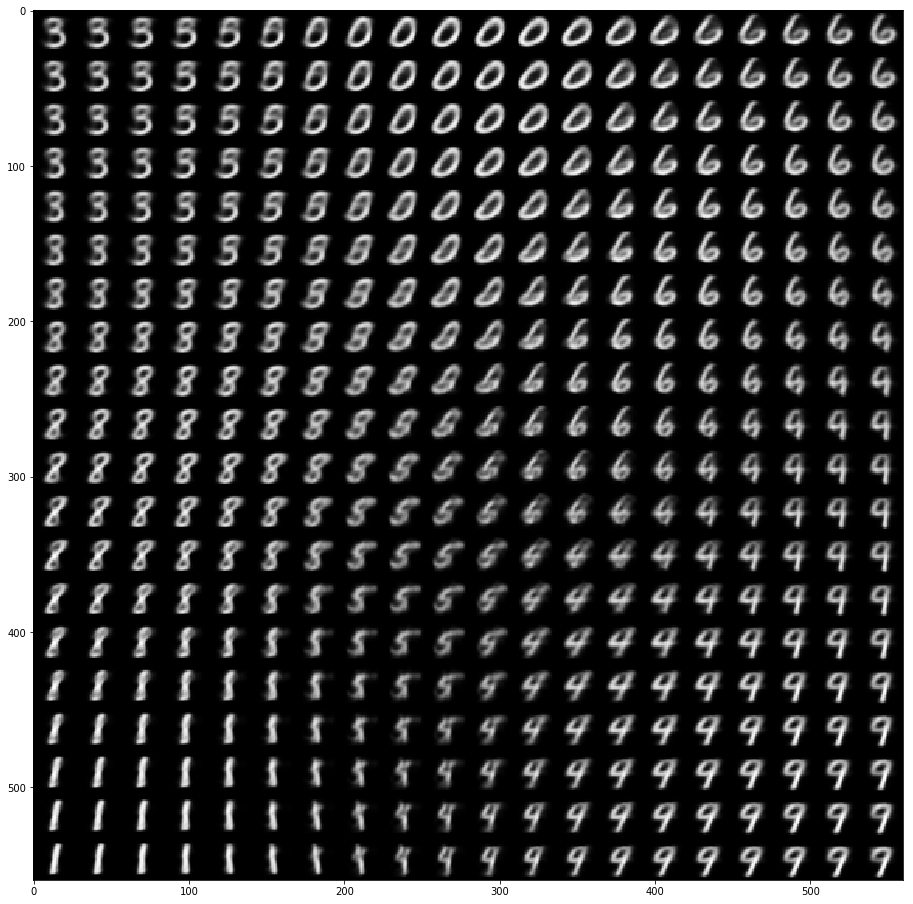

In [15]:
plt.figure(figsize=(16, 16))
plt.imshow(z_space_image, cmap='gray')

Latent space scatter

In [16]:
z_space_code, test_mean, test_log_sigma_squared = encoder.predict(x_test)
x, y = z_space_code.T

In [17]:
test_mean.mean(), test_mean.std()

(-0.022342646, 1.1871194)

In [18]:
np.exp(test_log_sigma_squared).mean(), np.exp(test_log_sigma_squared).std()

(0.03968646, 0.016135724)

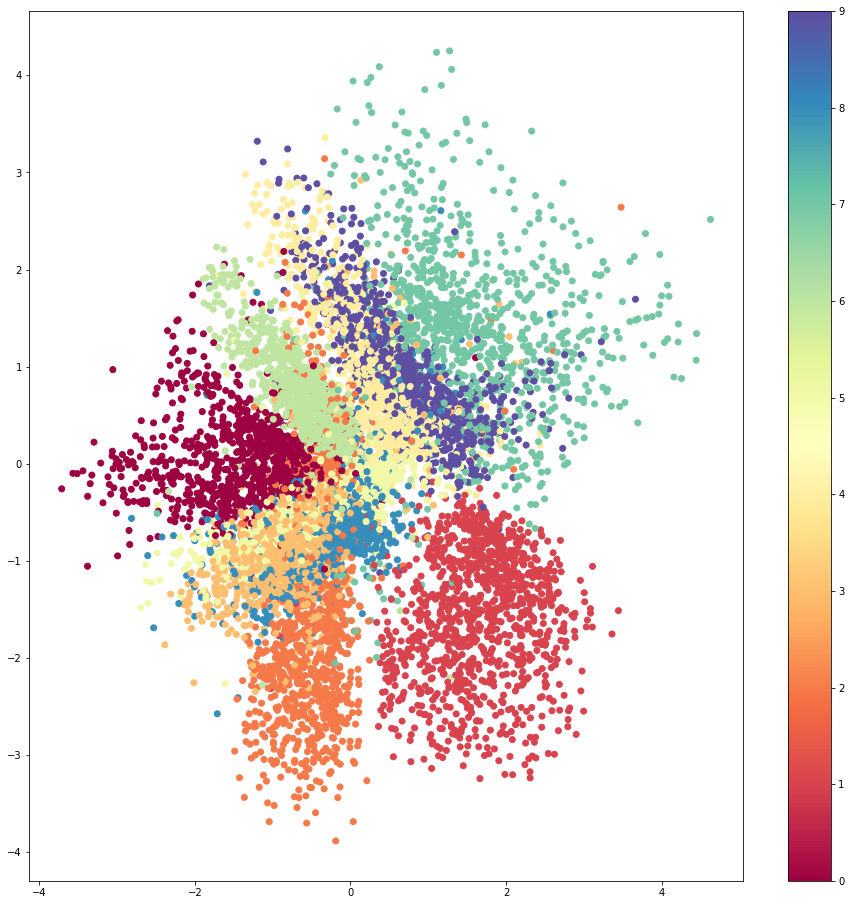

In [19]:
plt.figure(figsize=(16, 16))
plt.scatter(x, y, c=y_test, cmap=plt.cm.Spectral)
plt.colorbar()